In [2]:
import pandas as pd
import numpy as np
import pickle
import scanpy as sc
import anndata as ad
import random
import os

import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import matplotlib.colors
from plotnine import *

from sklearn.cluster import KMeans
from sklearn import metrics 
import pymannkendall as mk

from collections import Counter

In [3]:
FILES_PATH="./Figure3_data/"
files=os.listdir(FILES_PATH)

### 3b,3c,3d

In [4]:
fname=[file for file in files if "3b" in file][0]

adata=ad.read_h5ad(FILES_PATH+fname)
adata

/home/sayali/.local/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.


AnnData object with n_obs × n_vars = 617 × 128
    obs: 'c15x', 'n02x', 'dpt_pseudotime', 'n03x', 'AD'
    var: 'VarID'
    uns: 'diffmap_evals', 'iroot', 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

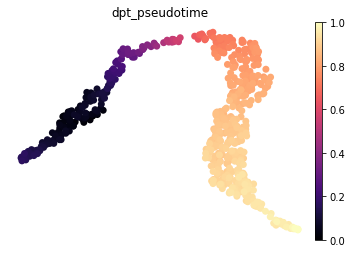

In [6]:
with plt.rc_context():  
    sc.pl.umap(adata, color=['dpt_pseudotime'],show=False, frameon=False, color_map="magma")
#     plt.savefig("fig3b_umap.png", bbox_inches="tight")

In [8]:
df = adata.obs

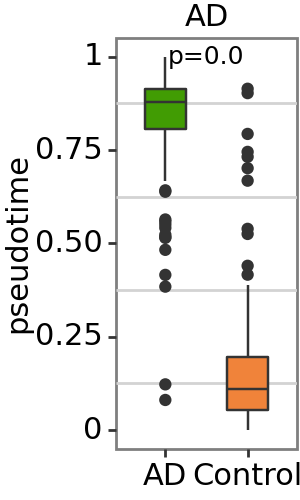

In [9]:
x="c15x"
xtitle=""
ytitle="pseudotime"
title="AD"
text=""

df=df.sort_values(by=[f"{x}"])
result = mk.original_test(df["dpt_pseudotime"].values)
if result.p > 0.0:
    text="p={:.2e}".format(result.p)
else:
    text="p={}".format(result.p)

p=(
    ggplot(df, aes(f"{x}","dpt_pseudotime", fill=f"{x}"))
    + geom_boxplot( aes(weight=2), fatten=1, width=0.5,)# fill="lightblue")#colour="#1F3552", )#fill="#4271AE") +
    + theme_bw() 
    + theme(
        panel_grid_major=element_blank(),#element_line(colour="#d3d3d3"),
        panel_grid_minor=element_line(colour="#d3d3d3"),
        axis_text_x=element_text(colour="black", size=11,angle = 0,),
        axis_text_y=element_text(colour="black", size=11),
         text=element_text(size=11),
         legend_position="none",
         legend_title=element_blank(),
        plot_title=element_text(size=11,ha="center"),
        plot_subtitle = element_text(size = 9, ha="center"),
         figure_size=(1.5,2.5),     )
    + xlab(f"{xtitle}")
    + ylab(f"{ytitle}")
     + scale_fill_manual(values={"Control": "#f0833a", "AD": "#419c03"})

  #+ geom_smooth(aes(group=1), method = "lm", color="black", linetype="dashed", size=0.5)
  + labs(title=f"{title}")#,subtitle =f"{text}",)  
  + annotate("text", x=1.5, y = 1, label=f"{text}", size=9)
      )
print (p)
# p.save("fig3b.png", dpi=300)

In [10]:
df=adata.obs
df=df.sort_values(by=["dpt_pseudotime"])

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
import statsmodels.api as sm

def plot_isotonic(df,n,ylabel,xlabel="pseudotime",save=False,save_path=""):
    X = df.dropna(subset=[n])["dpt_pseudotime"].values.reshape(-1, 1)  # iloc[:, 1] is the column of X
    Y = df.dropna(subset=[n])[n].values#.reshape(-1, 1)  # df.iloc[:, 4] is the column of Y
    linear_regressor = IsotonicRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    #print (f"R2: {round(linear_regressor.score(X, Y, sample_weight=None),3)}")
    
    mod = sm.OLS(X,Y)
    res = mod.fit()
    #print(res.summary(), res.pvalues)
    pval=round(res.pvalues[0],3)
    r2 = round(res.rsquared,3)

    plt.figure(figsize=(3,3))
    plt.scatter(X, Y,color="grey")
    plt.plot(X, Y_pred, color='red')
    plt.figtext(0.3, 0.84,  f'R2={r2}\np={pval}', size=10)
    plt.xlabel(f"{xlabel}",fontsize=12)
    plt.ylabel(f"{ylabel}",fontsize=12)
    plt.tight_layout()
    
    if save and save_path!="":
        plt.savefig(f"{save_path}/c15x_{ylabel}.png",dpi=300)
    elif save and save_path=="":
        print ("save path not provided!")
    plt.show()

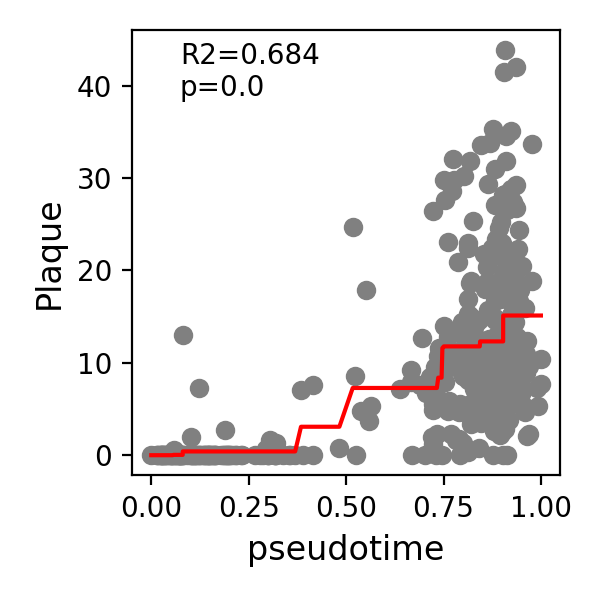

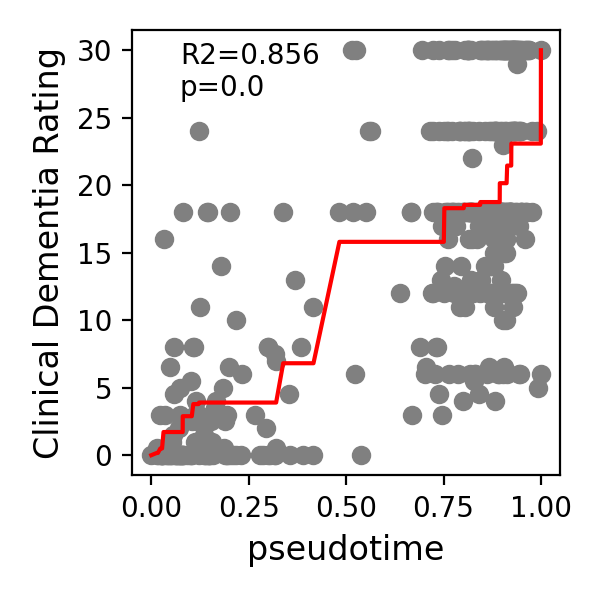

In [12]:
ad_pathology={"n02x":"Plaque","n03x":"Clinical Dementia Rating",}
for i in range(2,4):
    n=f"n0{i}x"
    plot_isotonic(df,n,ylabel=ad_pathology[n],)

### 3e.

In [14]:
files_sub = [file for file in files if "3e" in file and "stage" in file]
files_sub

['fig3e_CERAD_stage.h5ad', 'fig3e_CDR_stage.h5ad', 'fig3e_Braak_stage.h5ad']

In [15]:
def plot_grouped_bar(df,x="braak",text=None,title=None,save=None,xtitle="pseudotime",ytitle="percent of individuals"):
    p=(
        ggplot(df, aes(f"{x}","dpt_pseudotime"))
        + geom_boxplot( aes(weight=2), fatten=1, width=0.7, fill="lightblue")#colour="#1F3552", )#fill="#4271AE") +
        + theme_bw() 
        + theme(
            panel_grid_major=element_blank(),#element_line(colour="#d3d3d3"),
            panel_grid_minor=element_line(colour="#d3d3d3"),
            #panel_grid_minor=element_line(colour="#fe4e4e"),
            axis_text_x=element_text(colour="black", size=11,angle = 0,),
            axis_text_y=element_text(colour="black", size=11),
             text=element_text(size=11),
             legend_position="bottom",
             legend_title=element_blank(),
            plot_title=element_text(size=11,ha="center"),
            plot_subtitle = element_text(size = 9, ha="center"),
             figure_size=(3.5,2.5),
        #      aspect_ratio=(1/1.5)
         )
        + xlab(f"{xtitle}")
        + ylab(f"{ytitle}")
            
      + geom_smooth(aes(group=1), method = "lm", color="black", linetype="dashed", size=0.5)
      + labs(title=f"{title}")#,subtitle =f"{text}",)  
      + annotate("text", x=2, y = 1, label=f"{text}", size=9)
          )
    if save:
        p.save(f'{save}', dpi=300)
    print (p)

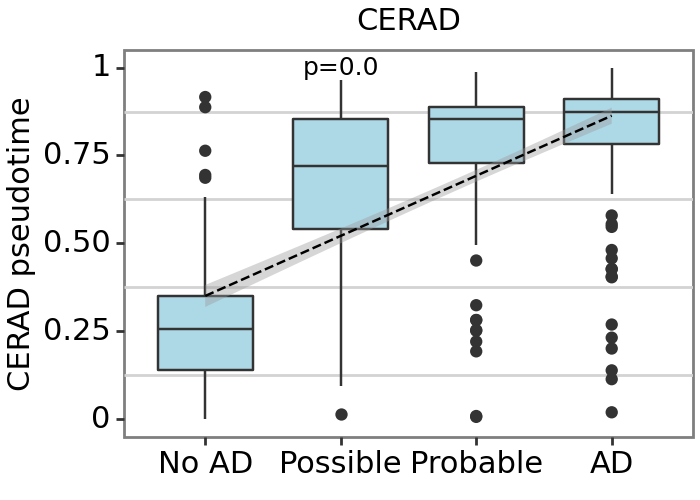

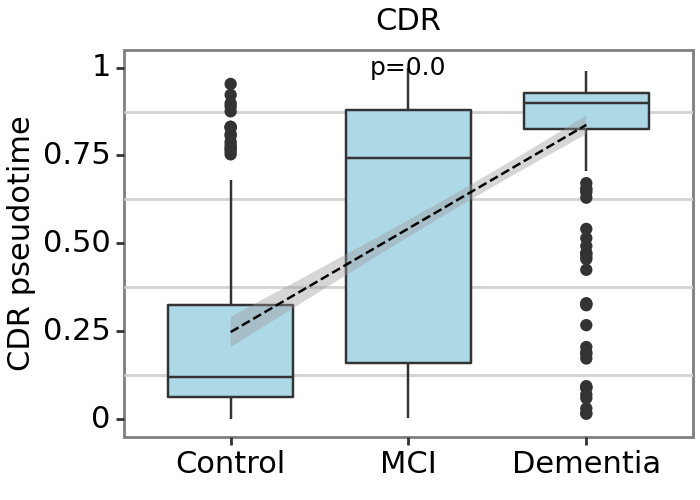

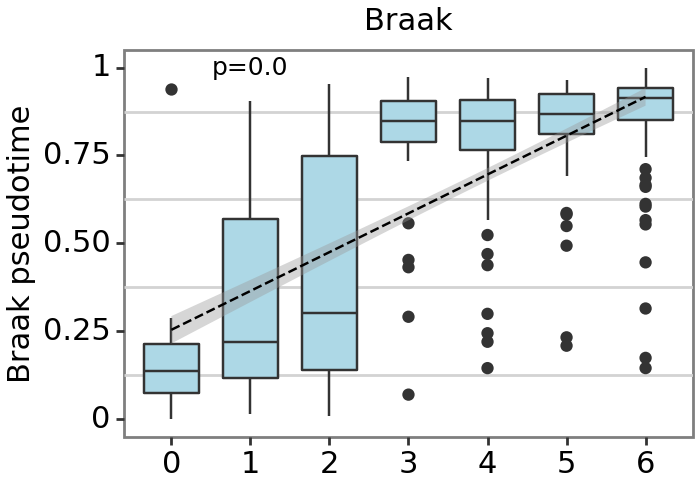

In [16]:
import warnings
warnings.filterwarnings('ignore')

for fname in files_sub:
    stage=fname.split("_")[1].split(".")[0]
    adata=ad.read_h5ad(FILES_PATH+fname)
    df=adata.obs[['braak','dpt_pseudotime','BRAAK','r03x','r05x']]
    
    if stage=="Braak": 
        df["braak"] = pd.Categorical(df['braak'], categories=["Early","Mid","Late"])
        df["Braak"] = pd.Categorical(df['BRAAK'], categories=['0', '1', '2', '3', '4', '5', '6'])
        df["Braak_names"] = pd.Categorical(df['BRAAK'], categories=['0', '1', '2', '3', '4', '5', '6'])
    elif stage=="CERAD":
        df["CERAD"] = pd.Categorical(df['r03x'], categories=[1., 2., 3., 4.])
        names={1:"No AD",2:"Possible",3:"Probable",4:"AD"}
        df[f"{stage}_names"]=df[f"{stage}"].map(names)
    elif stage=="CDR":
        df["CDR"] = pd.Categorical(df['r05x'], categories=[0. ,0.5,1. ,  2.,3., 4. , 5.  ])
        r05x_sub = []
        for x in df["r05x"].to_list():
            if x==0:
                r05x_sub.append("Control")
            elif x==0.5 or x==1:
                r05x_sub.append("MCI")
            elif x in [2,3,4,5]:
                r05x_sub.append("Dementia")
            else:
                r05x_sub.append(x)
        df[f"{stage}_names"] = r05x_sub
        df[f"{stage}_names"] = pd.Categorical(df[f"{stage}_names"], categories=["Control","MCI","Dementia"])


    df=df.sort_values(by=[f"{stage}"])
    result = mk.original_test(df["dpt_pseudotime"].values)

    if result.p > 0.0:
        p="p={:.2e}".format(result.p)
    else:
        p="p={}".format(result.p)
    
    plot_grouped_bar(df,x=f"{stage}_names", text=p,
                     title=f"{stage}",
                     xtitle="",ytitle=f"{stage} pseudotime")

### 3f.

In [30]:
files_sub = [file for file in files if "3f" in file and "stage" in file]
files_sub

['fig3f_c102x_stage.h5ad',
 'fig3f_c104x_stage.h5ad',
 'fig3f_c106x_stage.h5ad',
 'fig3f_c107x_stage.h5ad',
 'fig3f_c118x_stage.h5ad',
 'fig3f_c121x_stage.h5ad',
 'fig3f_c101x_stage.h5ad',
 'fig3f_c103x_stage.h5ad',
 'fig3f_c116x_stage.h5ad',
 'fig3f_c119x_stage.h5ad',
 'fig3f_c122x_stage.h5ad']

In [18]:
def plot_density(df, title,save=None,text=None, xtitle="pseudotime",ytitle="percent of individuals"):
    names=list(df["names"].unique())
    color_dict={}
    for c in names:
        if c=="Control":
            color_dict[c]="xkcd:grassy green"
        else:
            color_dict[c]="#f2e318"
    
    p=(ggplot(df,aes(x="key",fill="names")) +
        geom_density(alpha=0.2) +
        theme_bw() +
         theme(

            panel_grid_major=element_blank(),#element_line(colour="#d3d3d3"),
            panel_grid_minor=element_line(colour="#d3d3d3"),
            axis_text_x=element_text(colour="black", size=14,angle = 0,),
            axis_text_y=element_text(colour="black", size=14),
             text=element_text(size=14),
             legend_position=(0.55, 0.83),#"bottom",
             legend_direction="vertical",
             legend_background=element_blank(),
             legend_title=element_blank(),
             plot_title = element_text(hjust = 0.1,size=11,),
             plot_subtitle = element_text(size = 9, ha="center",hjust = 0.5,),
             figure_size=(4.5,3),
#              figure_size=(3,3),
        #      aspect_ratio=(1/1.5)
         )
        + annotate("text", x=0.5, y = 0.2, label=f"p<{text}", size=14)
        + xlab(f"{xtitle}")
        + ylab(f"{ytitle}")#\n       with AD")
        +ggtitle(f'{title}',)
        #+  labs(subtitle =f"ttest: p-value={text}")  
        #+ scale_fill_manual(values=color_dict)

          )
    if save:
        p.save(f'{save}', dpi=300)
    print (p)

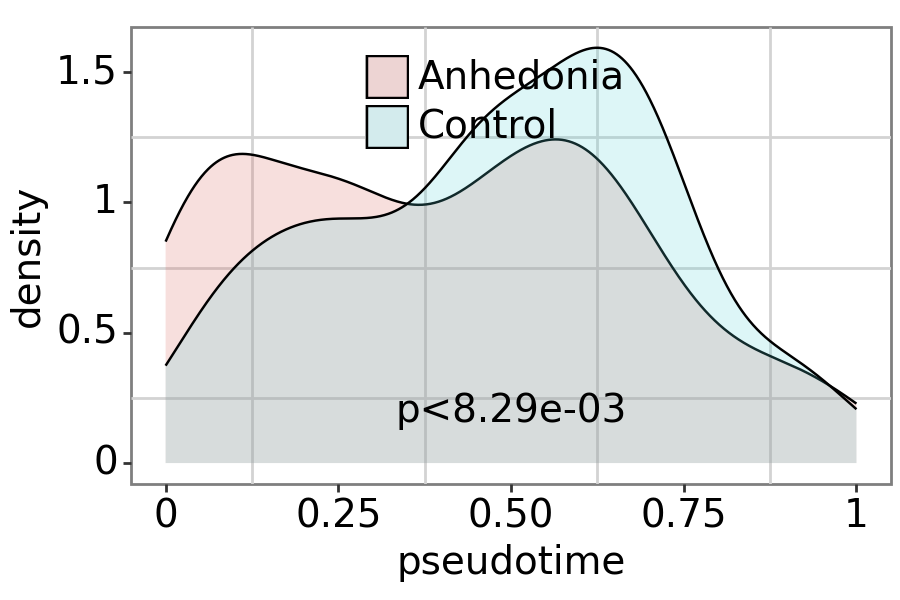

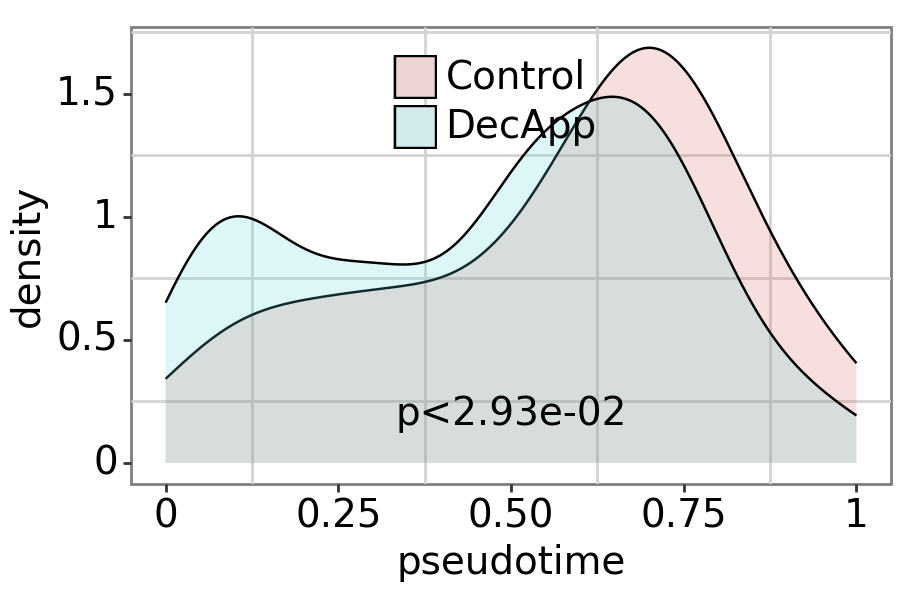

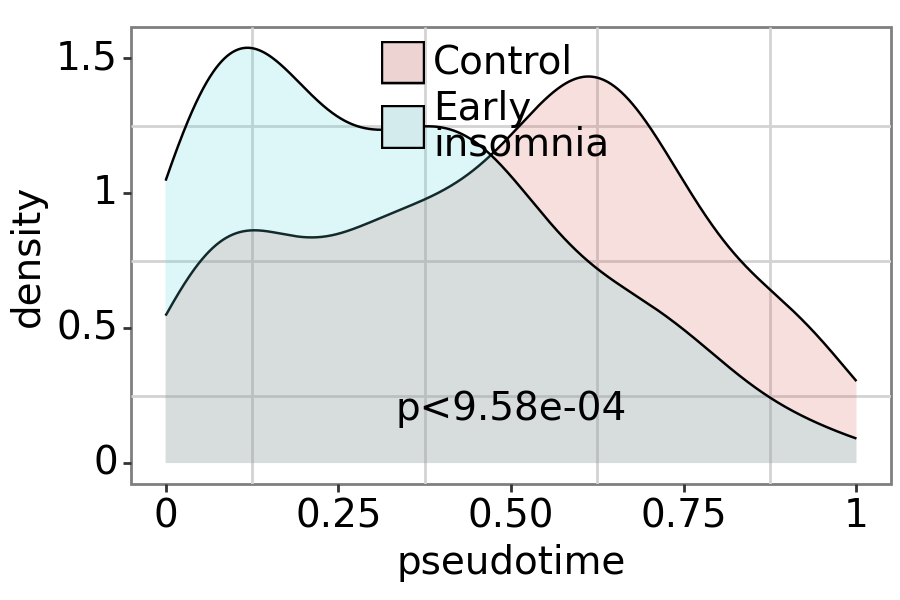

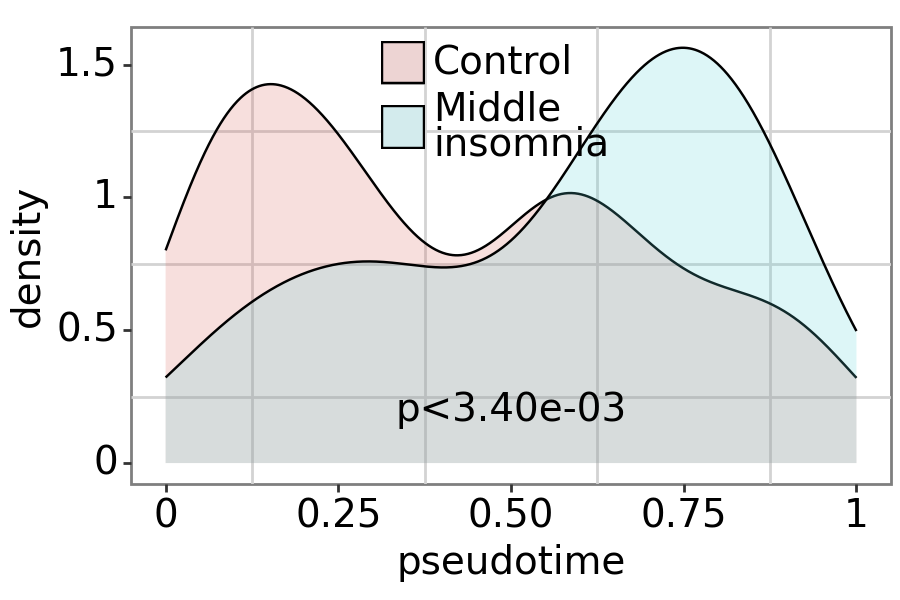

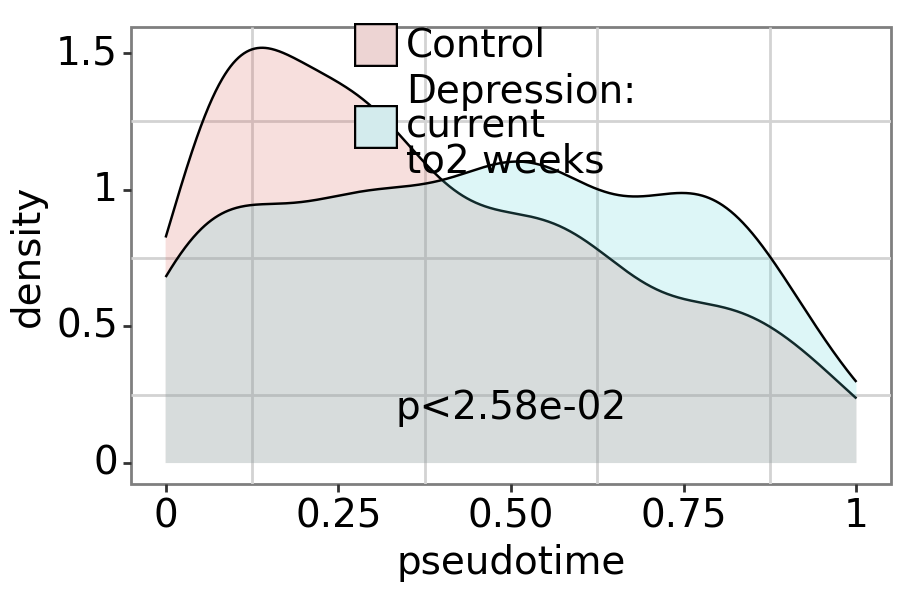

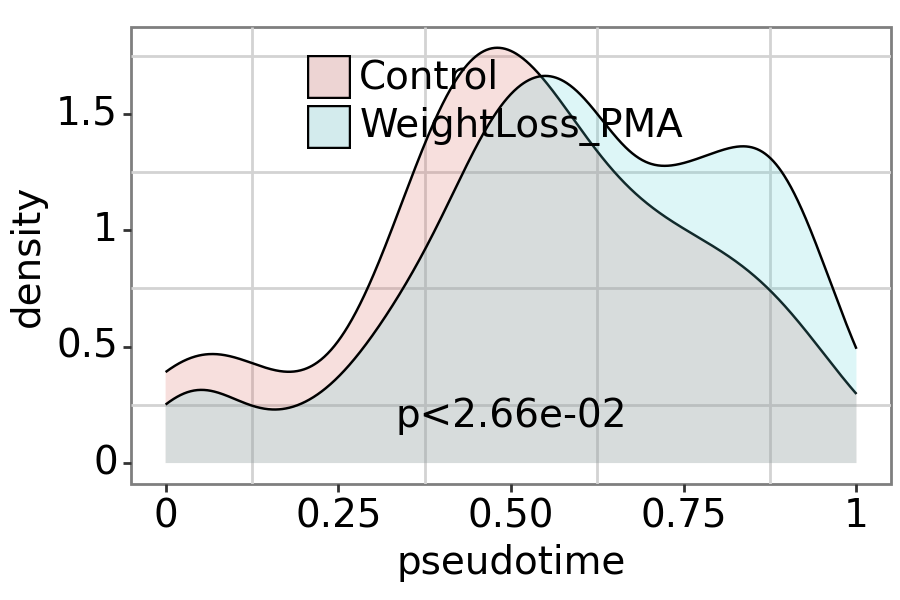

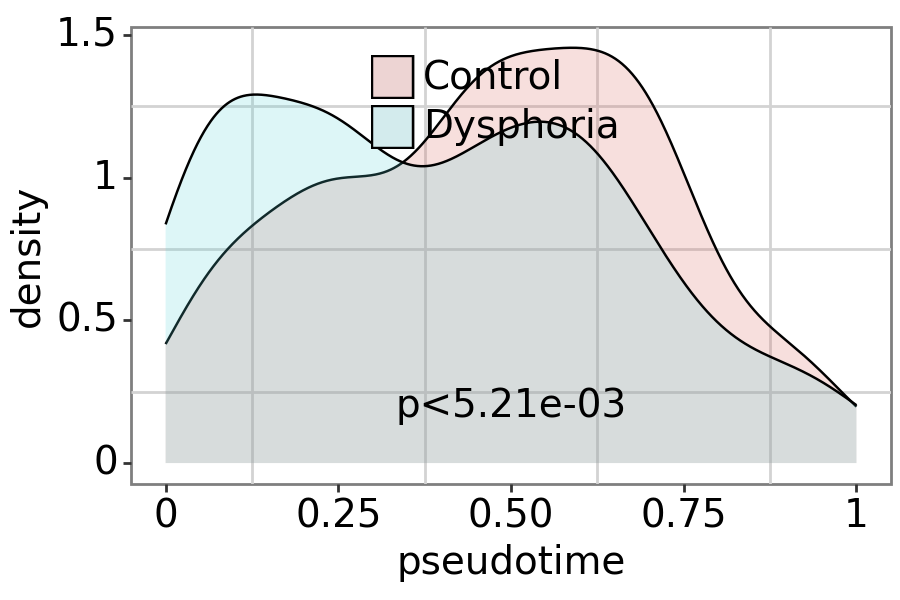

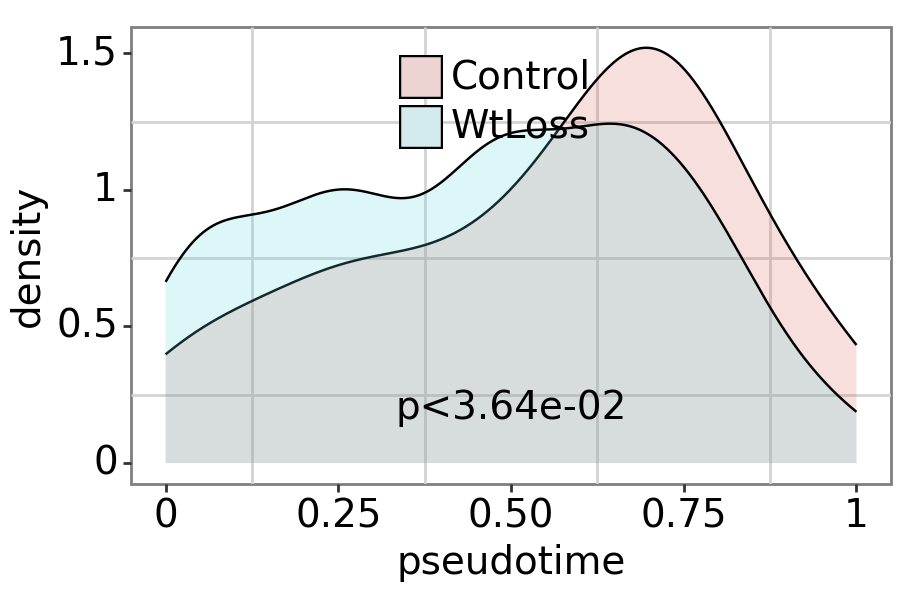

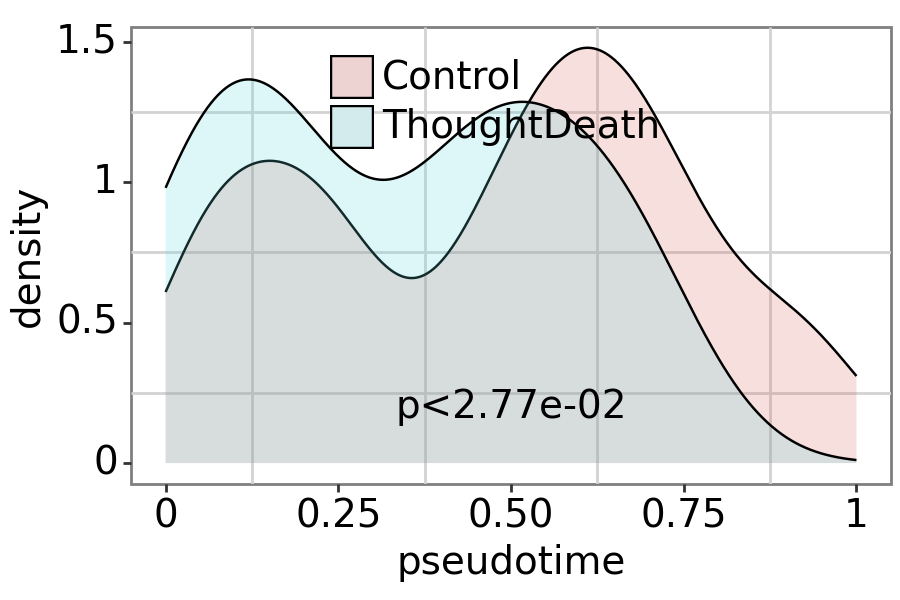

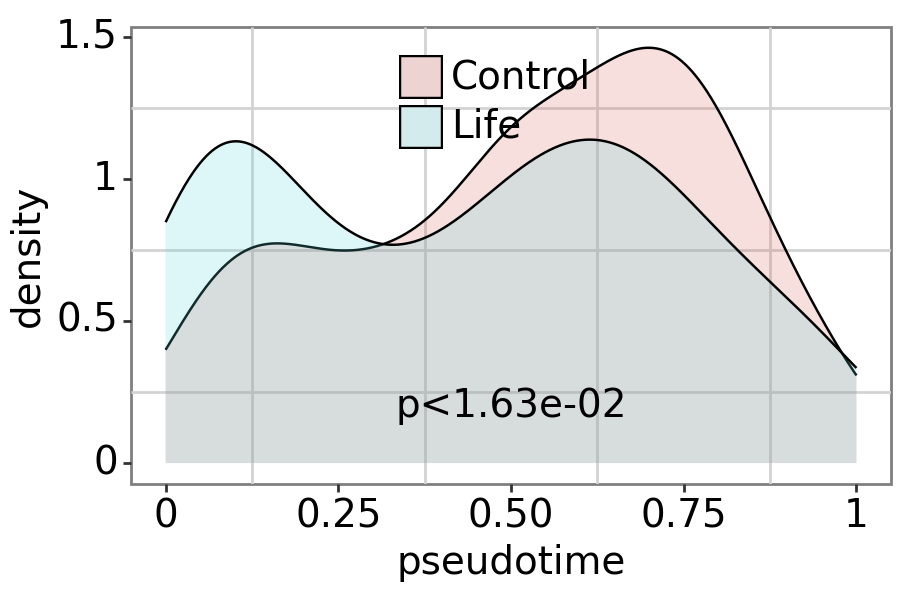

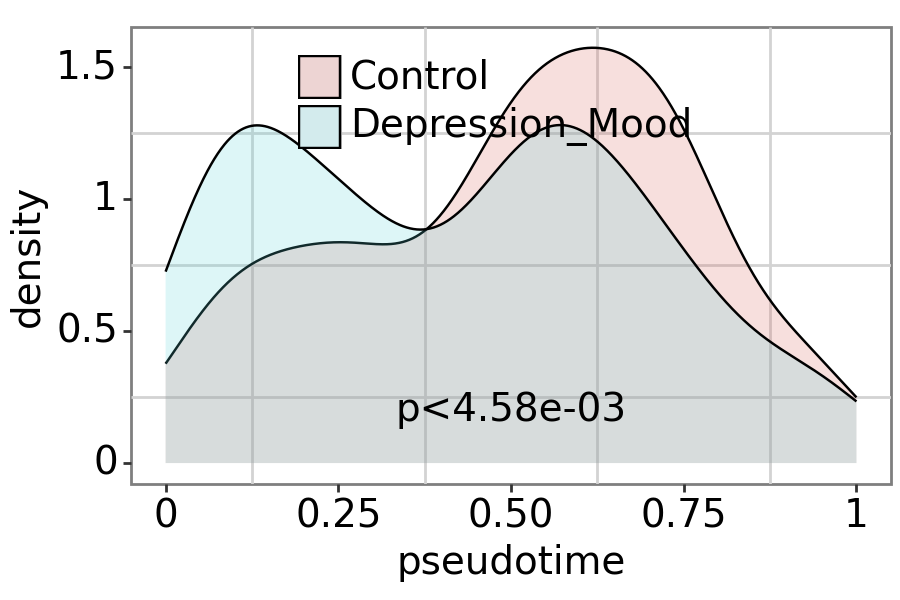

In [31]:
for fname in files_sub:
    i=fname.split("_")[1].split(".")[0]
    adata=ad.read_h5ad(FILES_PATH+fname)
    all_ind=adata.obs
    gr=all_ind.groupby(i)
    df=pd.DataFrame()
    arr=[]

    for n,g in gr:
        key=list(g["dpt_pseudotime"].to_list())
        arr.append(g["dpt_pseudotime"].to_list())
        if n=="MoodDys":
            n="Dysphoria"
        if n=="DecInt":
            n="Anhedonia"
        if n=="EarlyInsom":
            n="Early\ninsomnia"
        if n=="MidInsom":
            n="Middle\ninsomnia"
        if n=="PsychoAgi":
            n="Psychomotor\nagitation"
        if n=="SixMo":
            n="Depression:\ncurrent\nto2 weeks"
        if n=="Depression_MoodDys":
            n="Depression:\ncDysphoria"
        df=pd.concat([df, pd.DataFrame({"key":key, "names":[n]*len(key)})])

    tt=stats.ttest_ind(a=arr[0],b=arr[1])
    title=" vs. ".join(list(df["names"].unique()))

    if tt.pvalue <0.05:
        plot_density(df, title="",xtitle="pseudotime",ytitle="density", text="{:.2e}".format(tt.pvalue),
                 #save=f"3f_{n}.png",
                    )